In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Introduction

The dataset belongs to a shared bike system in Los Angeles which brings information about the service between the years 2016 and 2021. Each row of the dataset has anonymous information about a bike trip, and in particular, it has the column passholder_type, which is the variable of interest. 

A description of the columns is given below:

- trip_id: unique identifier of the trip
- duration: trip duration in minutes
- start_time: day/hour at which the trip begins 
- end_time: day/hour at which the trip ends
- start_station: station at which the trip begins
- start_lat: latitude of the beginning station
- start_lon: longitude of the beginning station
- end_station: station at which the trip ends
- end_lat: latitude of the ending station
- end_lon: longitude of the ending station
- bike_id: unique number that identifies each bike
- plan_duration: number of days that the user will have the pass. 0 means a unique trip (Walk-up plan)
- trip_route_category: “Round trip” are trips that start and end in the same station
- passholder_type: Name of the passholder plan

The passholder_type column has 6 different classes, so the problem is a multiclass classification. Moreover, even though the classes are highly imbalance, the point of the task is to maximize the overall accuracy.

kaggle reference:
https://www.kaggle.com/t/e82d8dd1223a4a459037106a2acab561

In [2]:
df = pd.read_csv('train_set.csv')
test = pd.read_csv('test_set.csv')

C:\Users\aguir\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3257: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station
0,101750280,35,2018-08-07 11:20:00,2018-08-07 11:55:00,33.748920,-118.275192,33.748920,-118.275192,06530,1.0,Round Trip,Walk-up,4127,4127
1,46560345,32,9/17/2017 17:51,9/17/2017 18:23,34.035679,-118.270813,34.047749,-118.243172,6683,0.0,One Way,Walk-up,3057,3062
2,120016336,6,2019-04-22 09:22:00,2019-04-22 09:28:00,34.046070,-118.233093,34.047749,-118.243172,06710,30.0,One Way,Monthly Pass,3022,3062
3,129547190,138,9/22/2019 11:27,9/22/2019 13:45,34.062580,-118.290092,34.059689,-118.294662,17068,1.0,One Way,One Day Pass,4304,4311
4,136619463,14,1/31/2020 17:11,1/31/2020 17:25,34.026291,-118.277687,34.021660,-118.278687,18841,30.0,One Way,Monthly Pass,4266,4443


# Data Cleaning

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   trip_id              700000 non-null  int64  
 1   duration             700000 non-null  int64  
 2   start_time           700000 non-null  object 
 3   end_time             700000 non-null  object 
 4   start_lat            694437 non-null  float64
 5   start_lon            694437 non-null  float64
 6   end_lat              681426 non-null  float64
 7   end_lon              681426 non-null  float64
 8   bike_id              700000 non-null  object 
 9   plan_duration        699792 non-null  float64
 10  trip_route_category  700000 non-null  object 
 11  passholder_type      697424 non-null  object 
 12  start_station        700000 non-null  int64  
 13  end_station          700000 non-null  int64  
dtypes: float64(5), int64(4), object(5)
memory usage: 74.8+ MB


- First, we can observe that the time columns are presented in two formats (dd/mm/yyyy or yyyy-mm-dd).
- plan_duration gives basically the same information that passholder_type
- bike_id has numerical strings
- trip_route_category contains basically the same information that start_station and end_station combined
- The longitud and latitude variables have a few missing values
- The passholder_type column and plan_duration also contain missing values

#### Correspondence between passholder_type and plan_duration

In [5]:
#Checking the correspondence 
df.groupby(['passholder_type','plan_duration'], as_index = False).size()

,passholder_type,plan_duration,size
0,Annual Pass,365.0,34092
1,Flex Pass,365.0,11604
2,Monthly Pass,30.0,393823
3,Monthly Pass,150.0,160
4,Monthly Pass,365.0,578
5,One Day Pass,1.0,44455
6,Testing,999.0,78
7,Walk-up,0.0,63275
8,Walk-up,1.0,140101
9,Walk-up,30.0,2779


Apparently, the correspondence between these columns is not unique, or some pass types are mislabeled. Yet, our task is to predict the passholder column, so an information like the plan_duration would be a huge data leakage in any model. Thus, we can ignore the plan_duration column in general. 

In [6]:
#Checking the correspondence between the 'plan_duration' Nan's and passholder_type
print(df[df['plan_duration'].isnull()]['passholder_type'].unique())

#Checking the correspondence between the 'passholder_type' Nan's and plan_duration
print(df[df['passholder_type'].isnull()]['plan_duration'].unique())

['Monthly Pass']
[30.]


In [7]:
#Since the correspondence in the Nan's is unique, we can fill them directly:
df['plan_duration'].fillna(30, inplace = True)
df['passholder_type'].fillna('Monthly Pass', inplace = True)

#### Correspondence between trip_route_category and start_station combined with end_station

In [8]:
#Checking the correspondence 

print("Rows where initial_station == final_station:")
print(df.query('start_station == end_station')['trip_route_category'].value_counts())

print("Rows where initial_station != final_station:")
print(df.query('start_station != end_station')['trip_route_category'].value_counts())

Rows where initial_station == final_station:
Round Trip    117863
One Way          368
Name: trip_route_category, dtype: int64
Rows where initial_station != final_station:
One Way       581708
Round Trip        61
Name: trip_route_category, dtype: int64


The fact that initial_station == final_station doesn't correspond uniquely with round trip, and similarly with initial_station != final_station and One Way, implies that again we have a mislabeled column. Since this variable is indeed important for the model development, we will have to amend it. For simplicity, we will create the new_column "is_roundtrip" and ignore trip_route_category:

In [9]:
#Creating the is_roundtrip variable
df['is_roundtrip'] = df['start_station'] == df['end_station']
test['is_roundtrip'] = test['start_station'] == test['end_station']

#### Correcting the format of the time columns

Before changing to datetime format, we label the rows of start_time that have different formats (dd/mm/yyyy or yyyy-mm-dd). This may or may not be useful in the future. Since the format coincides in start_time and end_time, we will only keep one columns for both formats.

In [10]:
#Format
df['date_format'] = df['start_time'].str.contains('/')
test['date_format'] = test['start_time'].str.contains('/')

In [11]:
#Changing the time variables to datetime
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

#Changing the time variables to datetime
test['start_time'] = pd.to_datetime(test['start_time'])
test['end_time'] = pd.to_datetime(test['end_time'])

#### Format of bike_id column

Here we explore the bike_id column since we already saw that it is composed of numeric and string-numeric rows (for example, "05635" differs from 5635): 

In [12]:
print("Number of strings and integers in bike_id column")
print(df['bike_id'].map(lambda x: type(x)).value_counts())

print("Number of numeric rows in bike_id column")
print(df['bike_id'].str.isnumeric().value_counts())

Number of strings and integers in bike_id column
<class 'str'>    634464
<class 'int'>     65536
Name: bike_id, dtype: int64
Number of numeric rows in bike_id column
True     634447
False        17
Name: bike_id, dtype: int64


Thus, we can see that the number of numeric strings does not match the number of total strings. The non-numeric strings in the column are the following:

In [13]:
print("Non-numeric string in the bike_id column in the training dataframe")
print(df[df['bike_id'].str.isnumeric() == False]['bike_id'].value_counts())
print("Non-numeric string in the bike_id column in the test dataframe")
print(test[test['bike_id'].str.isnumeric() == False]['bike_id'].value_counts())

Non-numeric string in the bike_id column in the training dataframe
_Test_RFID        6
15111a            4
Dock Block 2      2
16015a            2
TBlocker_Slash    1
Dock Block 1      1
Rblock            1
Name: bike_id, dtype: int64
Non-numeric string in the bike_id column in the test dataframe
_Test_RFID        7
16015a            6
Dock Block 2      2
Rblock            2
15229a            2
15241b            1
15111a            1
TBlocker_Slash    1
Dock Block 1      1
Name: bike_id, dtype: int64


In [14]:
#Fixing the type of bike_id column.
#The process is numeric strings -> to int, then the non-numeric strings --> to negative integers


#Fixing training dataframe
##-------------------------------------------------------------------------------------------------------
#Changing numeric strings to integer
df['bike_id'] = df['bike_id'].apply(lambda x: pd.to_numeric(x, errors = 'ignore'))

#Filling for the remaining strings (non-numeric)
bike_string = {} #Making a dictionary to save the strings
for i_bike, bike in enumerate(df[df['bike_id'].map(lambda x: isinstance(x,str))]['bike_id'].unique()):
    df['bike_id'].replace(to_replace= bike , value= -(i_bike+1), inplace = True)
    
    #Saving the string in a dictionary
    bike_string[ bike ] =  -(i_bike+1) 
##-------------------------------------------------------------------------------------------------------
    
    
#Fixing the test dataframe
##-------------------------------------------------------------------------------------------------------
#Changing string numerics to integer
test['bike_id'] = test['bike_id'].apply(lambda x: pd.to_numeric(x, errors = 'ignore'))

#Replacing the non-numeric strings with the labels of the training data
test['bike_id'].replace(bike_string, inplace = True)

#Filling for the remaining strings (non-numeric that did not appear in the training data)
for i_bike, bike in enumerate(test[test['bike_id'].map(lambda x: isinstance(x,str))]['bike_id'].unique()):
    current_i_bike = len(bike_string) #starts the labeling from the last label in the bike_string
    test['bike_id'].replace(to_replace= bike , value= -(current_i_bike+1), inplace = True)
    
    #Saving the string in a dictionary
    bike_string[ bike ] =  -(current_i_bike+1)
##-------------------------------------------------------------------------------------------------------


In [15]:
print("Number of bikes = {}".format(df['bike_id'].nunique()))

Number of bikes = 3365


In [16]:
print('N of unique start stations: {0}, N of unique end stations: {1}'.format(\
      df['start_station'].nunique(), df['end_station'].nunique()))

N of unique start stations: 364, N of unique end stations: 369


#### Dealing with outlier locations

The locations have different levels of outliers:

- Overall outliers, i.e., those that are so far away that simply are unrealistic (depicted in the left panel ahead).

- Station outliers, i.e., those that still close to all the locations but very far from the station location mean. An example would be the most right data point in the right panel ahead.

In [17]:
#Building a unique dataframe with the start and end locations:
all_locations = pd.concat((df[['start_lon','start_lat','start_station']].rename(columns={'start_lon':'lon','start_lat':'lat','start_station':'station'}),\
                       df[['end_lon','end_lat','end_station']].rename(columns={'end_lon':'lon','end_lat':'lat','end_station':'station'})))
all_locations.dropna(inplace=True)

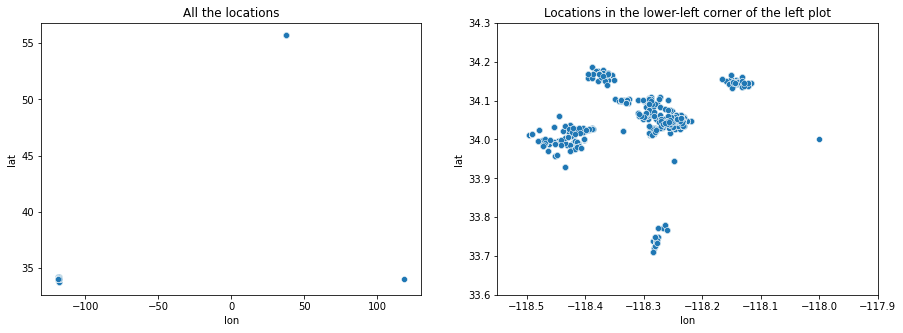

In [18]:
#Outlier locations are clearly observable from an scatterplot
f, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].title.set_text('All the locations')
sns.scatterplot(data=all_locations, x = 'lon', y = 'lat', ax = ax[0])
ax[1].title.set_text('Locations in the lower-left corner of the left plot')
sns.scatterplot(data=all_locations, x = 'lon', y = 'lat', ax = ax[1])
ax[1].set_xlim(-118.55, -117.9)
ax[1].set_ylim(33.6,34.3)
plt.show()

We can easily trace the outliers by aggregating some statistics as following:

In [19]:
station_locations_statistics = all_locations.groupby(['station'])[['lat','lon']].\
                    agg(lon_median=('lon','median'), lon_max = ('lon','max'), lon_min = ('lon','min'), lon_var=('lon','var'),\
                        lat_median=('lat','median'), lat_max = ('lat','max'), lat_min = ('lat','min'), lat_var=('lat','var'))

station_locations_statistics['total_variance'] = station_locations_statistics['lon_var'] + station_locations_statistics['lat_var']

#Sorting by highest variance
station_locations_statistics.dropna().sort_values('total_variance').tail(10)

,lon_median,lon_max,lon_min,lon_var,lat_median,lat_max,lat_min,lat_var,total_variance
station,,,,,,,,,
4381,-118.402222,-118.402222,-118.402657,2.204710e-08,34.000210,34.000332,33.998798,2.735461e-07,2.955932e-07
3063,-118.253738,-118.252830,-118.253738,1.738665e-07,34.048038,34.049198,34.048038,2.842556e-07,4.581221e-07
4345,-118.481552,-118.479752,-118.481552,4.794710e-07,33.995560,33.995579,33.995281,1.233360e-08,4.918046e-07
4505,-118.463333,-118.431572,-118.463333,8.743349e-05,33.969730,33.984890,33.969730,1.991993e-05,1.073534e-04
4373,-118.425377,-118.372849,-118.425377,4.598651e-04,34.036770,34.161709,34.036770,2.601626e-03,3.061491e-03
4374,-118.361870,-118.361870,-118.425308,9.637331e-04,34.168751,34.168751,34.036621,4.180812e-03,5.144545e-03
4321,-118.453629,-118.000000,-118.453629,7.349260e-03,34.031399,34.031399,34.000000,3.521061e-05,7.384470e-03
4395,-118.495422,-118.370163,-118.495422,3.359744e-03,34.011570,34.162891,33.984821,5.281766e-03,8.641510e-03
3039,-118.393867,118.238258,-118.393867,4.274409e+02,34.024479,34.025959,34.024479,1.672061e-08,4.274409e+02


- The large total variance of station 3039 and 4496 shows that these stations contain the biggest outliers. This can be verified in the max/min values of lon and lat.
- The minimum latitude value in station 4321 shows an "station outlier". In fact, most of the total variance in this station comes from this datapoint (the most right in the right panel of the previous plot).
- Stations with a total variance lower than 10^-4 have basically the same location always.
- Stations with a total variance higher than 10^-4 are stations with multiple locations. Apparently, these stations were moved throughout the year. As an example, we can observe the different locations of station 4373 and 4395:

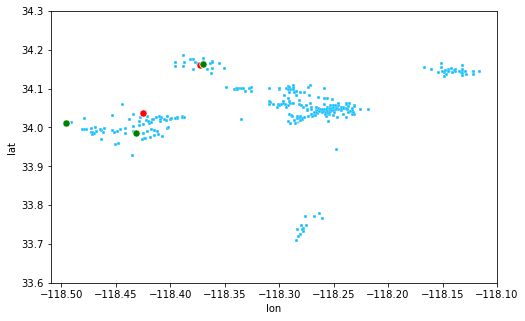

In [20]:
plt.figure(figsize = (8,5))
sns.scatterplot(data=all_locations, x = 'lon', y = 'lat', s = 5, color = 'deepskyblue', alpha = 0.3)
sns.scatterplot(data=all_locations.query('station == 4373'), x = 'lon', y = 'lat',s=50,color='red', alpha = 1)
sns.scatterplot(data=all_locations.query('station == 4395'), x = 'lon', y = 'lat',s=50,color='green', alpha = 1)
plt.xlim(-118.51, -118.1)
plt.ylim(33.6,34.3)
plt.show()

Next we check that each of these locations correspond to different time periods:

In [21]:
#This function extracts the locations of a given station a given month-year
def locations_by_year_month(df, station):
    if 'start_year_month' not in df.keys() and 'end_year_month' not in df.keys():
        df['start_year_month'] = df['start_time'].dt.strftime('%Y-%m')
        df['end_year_month'] = df['end_time'].dt.strftime('%Y-%m')
        
    year_month_locs =\
    pd.concat([df.query('start_station == {}'.format(station))[['start_year_month','start_lon','start_lat']].drop_duplicates().\
               rename(columns={'start_year_month':'year_month','start_lon':'lon','start_lat':'lat'}),\
               df.query('end_station == {}'.format(station))[['end_year_month','end_lon','end_lat']].drop_duplicates().\
               rename(columns={'end_year_month':'year_month','end_lon':'lon','end_lat':'lat'})]).drop_duplicates()
    return year_month_locs

In [22]:
locations_by_year_month(df, 4395)

,year_month,lon,lat
136557,2019-09,-118.495422,34.011570
158239,2019-05,-118.370163,34.162891
431946,2019-10,-118.431129,33.984821


In [23]:
locations_by_year_month(df, 4373)

,year_month,lon,lat
252719,2019-03,-118.425377,34.036770
466091,2019-04,-118.372849,34.161709


Thus, the variability in the location of these stations seems legit and not a data collection error. 

At the end, the treatment for the outliers will be changing them to NaN if they are outside the ranges range lon = (-118.5,-118.1) and lat=(33.65, 34.2), and subsequently filling these values. The next class performs the change to NaN:

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted


class Outliers_to_NaN(BaseEstimator, TransformerMixin):
    # initializer 
    
    def __init__(self, lon_range=[-118.5, -118.1], lat_range = [33.65, 34.2]):
        self.lon_range_min = lon_range[0]
        self.lon_range_max = lon_range[1]
        self.lat_range_min = lat_range[0]
        self.lat_range_max = lat_range[1]
        
    def fit(self, X, y = None):
        return self   
    
    def transform(self, X, y = None):
        # return the dataframe with the specified features
        X_copy = X.copy()
        X_copy['start_lon'].mask( (X_copy['start_lon'] > self.lon_range_max) | (X_copy['start_lon'] < self.lon_range_min), other = np.nan,inplace=True )
        X_copy['start_lat'].mask( (X_copy['start_lat'] > self.lat_range_max) | (X_copy['start_lat'] < self.lat_range_min), other = np.nan,inplace=True )
        X_copy['end_lon'].mask( (X_copy['end_lon'] > self.lon_range_max) | (X_copy['end_lon'] < self.lon_range_min), other = np.nan,inplace=True )
        X_copy['end_lat'].mask( (X_copy['end_lat'] > self.lat_range_max) | (X_copy['end_lat'] < self.lat_range_min), other = np.nan,inplace=True )
        return X_copy

### Filling Location NaN's

The most straightforward way to impute missing longitudes and latitudes of a given station is by using the median location of this station from the rows where these values exists. A SimpleImputer doesn't work here since the imputation needs to group by the station labels; therefore, here we build an imputer that makes the grouping and afterwards the imputation:

In [59]:
from sklearn.base import BaseEstimator, TransformerMixin

class GroupMedianImputer(BaseEstimator, TransformerMixin):
    def __init__(self, group_var):
        self.group_var = group_var
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        # the copy leaves the original dataframe intact
        X_ = X.copy()
        for col in X_.columns:
            if X_[col].dtypes == 'float64':
                X_.loc[(X[col].isna()) & X_[self.group_var].notna(), col] = X_[self.group_var].map(X_.groupby(self.group_var)[col].median())
                X_[col] = X_[col].fillna(X_[col].mean())
        return X_

The benefit of building this as a class is that we can use it in Pipelines to avoid data leakage from imputation

### Missing stations

Although we can fill NaN locations with median values, there are a few stations that never display any location at all. In particular, stations 4285 and 4286, as shown ahead:

In [26]:
df.groupby('start_station').agg(lon_median = ('start_lon','median'), lat_median = ('start_lat','median')).sort_values('lon_median')

,lon_median,lat_median
start_station,,
4395,-118.495422,34.011570
4215,-118.491341,34.014309
4344,-118.491341,34.014309
4214,-118.481552,33.995560
4345,-118.481552,33.995560
...,...,...
4166,-118.121750,34.145908
4159,-118.116539,34.145901
4496,37.606541,55.705528


Then, in this case we will infer their position from nearby stations.

Keeping only the trips starting from the unknown stations and reaching other stations in less than 10 minutes, an optimization problem can be stated:

Find $x_{unknown}$, $y_{unknown}$ and $c$ such that minimize the following expression:

$\sum_{i} [c^{2}t^{2}_{i} - (x_{unknown} - x_{i})^{2} - (y_{unknown} - y_{i})^{2}]^{2}$

where $x_{unknown}$, $y_{unknown}$ are the coordinates of the unknown stations, $t_{i}$ is the time that it took to get to the station $i$ located at $x_{i}$, $y_{i}$, and $c$ is the mean velocity in the trip (assumed the same for all the rides).

The following class performs this imputation as a transformer:

In [27]:
#Function to minimize
def square_distance_sum(position_unk, *args_nearby):
    #Variables of function
    x_unk, y_unk, c = position_unk
    
    #Parameters of function
    x_nearby, y_nearby, time = args_nearby
    
    summ = 0
    for point, time_point in enumerate(time):
        summ = summ + ((c*time_point)**2 - (x_nearby[point] - x_unk)**2 - (y_nearby[point] - y_unk)**2)**2        
    return summ


#Searching x_{i}, y_{i} and t_{i} for trips that took less than max_time minutes to the unknown_station
def near_data(df, max_time, unknown_station):
    nearby_data = df.query('start_station == {0} and duration < {1} and start_station != end_station'.format\
                           (unknown_station, max_time)).copy()
    nearby_data.dropna(axis = 0, subset = ['end_lat'], inplace = True)
    nearby_data.dropna(axis = 0, subset = ['end_lon'], inplace = True)

    nearby_lat = nearby_data['end_lat'].values
    nearby_lon = nearby_data['end_lon'].values
    time = nearby_data['duration'].values
    return nearby_lat, nearby_lon, time

#This will be used to minimize the square_distance_sum function
from scipy.optimize import minimize


from sklearn.base import BaseEstimator, TransformerMixin

class MissingStationsImputer(BaseEstimator, TransformerMixin):
    # initializer 
    
    def __init__(self, max_time = 10):
        self.max_time = max_time
    
    def fit(self, X, y = None):
        #This part finds the stations that have NaN in all their locations, i.e., missed stations.
        ##-----------------------------------------------------------------------------------------------------------------
        #Building the dataframe with all the locations
        all_locations = pd.concat((X[['start_lon','start_lat','start_station']].rename(columns={'start_lon':'lon','start_lat':'lat','start_station':'station'}),\
                       X[['end_lon','end_lat','end_station']].rename(columns={'end_lon':'lon','end_lat':'lat','end_station':'station'})))
        
        #Median of all the stations
        locations_medians = all_locations.groupby('station',as_index=False).agg(lon_median=('lon','median'), lat_median=('lat','median'))
        
        #Stations with missing location are those with NaN in lon_median and lat_median
        self.stations_missing = \
        locations_medians[locations_medians['lon_median'].isnull() & locations_medians['lat_median'].isnull()]['station'].unique()
        ##-----------------------------------------------------------------------------------------------------------------
        
        
        #This part finds the latitude and longitude for the missing stations 
        ##-----------------------------------------------------------------------------------------------------------------
        locations_missed_station = []
        #Loop for each missing station
        for station in self.stations_missing:
            near_data_to_missed_station = near_data(X, self.max_time, station)
            minimized = minimize(square_distance_sum, args = near_data_to_missed_station, x0 = np.array([near_data_to_missed_station[0].mean(), near_data_to_missed_station[1].mean(),1]))
            lat_missed_station, lon_missed_station = minimized.x[0], minimized.x[1]
            
            #saving
            locations_missed_station.append([station,lon_missed_station,lat_missed_station])
            
        #DataFrame with the missing stations and the fitted locations
        self.locations_missed_station = pd.DataFrame(locations_missed_station, columns = ['station','lon','lat'])
        
        ##-----------------------------------------------------------------------------------------------------------------
                
        return self   
    
    def transform(self, X, y = None):
        X_copy = X.copy()
        for station in self.stations_missing:

            mask = X_copy['start_station']==station
            X_copy.loc[mask,'start_lat'] = X_copy.loc[mask,'start_lat'].\
            fillna(self.locations_missed_station.query('station=={}'.format(station))['lat'].values[0])
        
            mask = X_copy['start_station']==station
            X_copy.loc[mask,'start_lon'] = X_copy.loc[mask,'start_lon'].\
            fillna(self.locations_missed_station.query('station=={}'.format(station))['lon'].values[0])

            mask = X_copy['end_station']==station
            X_copy.loc[mask,'end_lat'] = X_copy.loc[mask,'end_lat'].\
            fillna(self.locations_missed_station.query('station=={}'.format(station))['lat'].values[0])
            
            mask = X_copy['end_station']==station
            X_copy.loc[mask,'end_lon'] = X_copy.loc[mask,'end_lon'].\
            fillna(self.locations_missed_station.query('station=={}'.format(station))['lon'].values[0])
           
        return X_copy

Again, it is beneficial to express the imputation as a class in order to avoid data leakages.

Example of putting all this imputations together:

In [28]:
df_copy = df.copy()

df_copy = Outliers_to_NaN().transform(df_copy)
df_copy[['start_station','start_lat','start_lon']] = GroupMedianImputer('start_station').fit_transform(df_copy[['start_station','start_lat','start_lon']])
df_copy[['end_station','end_lat','end_lon']] = GroupMedianImputer('end_station').fit_transform(df_copy[['end_station','end_lat','end_lon']])
df_copy = MissingStationsImputer().fit_transform(df_copy)

Visualizing the imputed stations (red and orange dots):

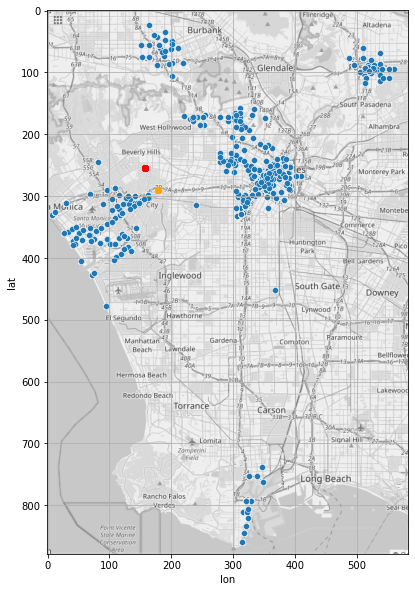

In [29]:
#Rescaling the coordinates from longitude, latitude units to image units:

#Building a unique dataframe with the start and end locations in df_copy:
all_locations = pd.concat((df_copy[['start_lon','start_lat','start_station']].rename(columns={'start_lon':'lon','start_lat':'lat','start_station':'station'}),\
                       df_copy[['end_lon','end_lat','end_station']].rename(columns={'end_lon':'lon','end_lat':'lat','end_station':'station'})))


#Image size in lon, lat: upper left corner: (-118.5, 34.2), lower right corner (-118.1, 33.7)
upper_left_corner_lon = -118.5
upper_left_corner_lat = 34.2
lower_right_corner_lon = -118.1
lower_right_corner_lat = 33.7

#Size in longitude and latitude
gps_width = lower_right_corner_lon - upper_left_corner_lon
gps_height = lower_right_corner_lat - upper_left_corner_lat


from PIL import Image
#Size in image units
image = Image.open('map.png') 
img_width = image.size[0]
img_height = image.size[1]

#Positions scaled to the image size
positions_img_coord = all_locations.copy()
positions_img_coord['lon'] = (positions_img_coord['lon'] - upper_left_corner_lon) *(img_width/gps_width)
positions_img_coord['lat'] = (positions_img_coord['lat'] - upper_left_corner_lat) *(img_height/gps_height)

#Plotting the result
fig, axis = plt.subplots(figsize=(17, 10))
axis.imshow(image.convert('L'), cmap='gray', vmin=0, vmax=255)  # Load the image to matplotlib plot. 
sns.scatterplot(data=positions_img_coord,x='lon',y='lat', alpha = 1,ax=axis)
plt.scatter(positions_img_coord.query('station == 4285')['lon'],positions_img_coord.query('station == 4285')['lat'],c='r')
plt.scatter(positions_img_coord.query('station == 4286')['lon'],positions_img_coord.query('station == 4286')['lat'],c='orange')
axis.grid()
plt.show()

We can observe that the imputation of missing stations gives sensible locations. As well, there are five noticeable clusters (and a few outliers); later, we will perform some clustering to the locations to exploit this fact.

## Exploratory Data Analysis

Throughtout the exploration, we will work with df_copy to avoid altering the original df.

### Distribution of the target variable (passholder_type)

<AxesSubplot:xlabel='passholder_type', ylabel='Count'>

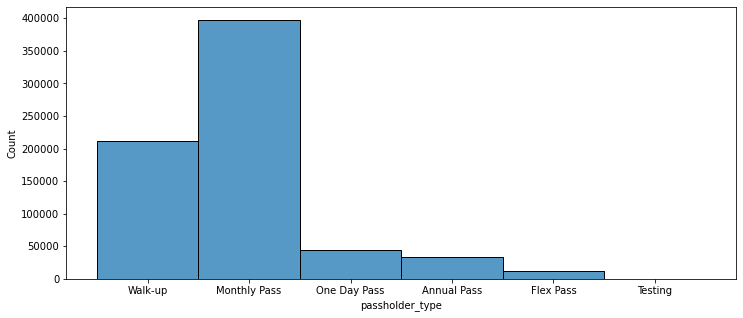

In [30]:
plt.figure(figsize = (12,5))
sns.histplot(data=df_copy, x = 'passholder_type')

The target variable has six classes, with a high imbalance between them. Thus, this makes it necessary to employ stratified folds in cross validation.

### Type of route variable (is_roundtrip)

Let's chheck the frecuency of is_roundtrip variable for the different classes in the target variable

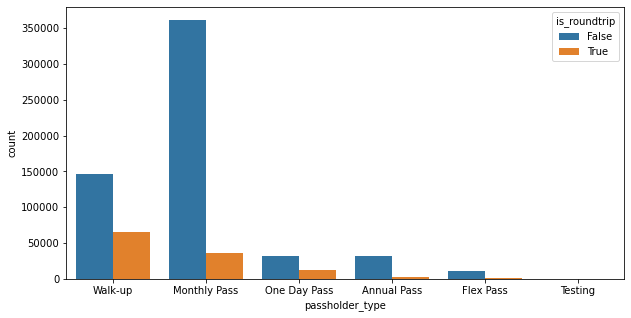

In [31]:
plt.figure(figsize=(10,5))
sns.countplot(data=df_copy, x='passholder_type', hue = 'is_roundtrip')
plt.show()

It seems like long-term passes (monthly and annual) have a lower proportion of True/False than short-term passes (walk-up and one day). Thus, it would be interesting to analyze this proportion by class:

In [32]:
proportions = pd.DataFrame(index = df_copy['passholder_type'].unique())

#Obtaining the proportions from a third of the whole dataset and repeating with replacement 10 times.
for i in range(10):    
    proportions = pd.concat([proportions, df_copy.sample(frac = 0.3).groupby('passholder_type')['is_roundtrip'].mean()], axis = 1)
    
proportions['mean_proportion'] = proportions.mean(axis = 1)
proportions['std_proportion'] = proportions.std(axis = 1)
proportions[['mean_proportion','std_proportion']]

,mean_proportion,std_proportion
Walk-up,0.311796,0.001632
Monthly Pass,0.090507,0.000657
One Day Pass,0.288759,0.002630
Annual Pass,0.077221,0.001848
Flex Pass,0.048651,0.002088
Testing,0.566133,0.100140


- The proportions in the short-term passes are very close each other (~ 0.3), as well as in the long-term passes (~ 0.08). The value for the flex pass is a bit lower than for monthly and annual, but still close, thus infering that it is kind of a long-term pass. 
- The proportion in the testing pass is considerably larger than the others. 

### Date Format

A similar analysis of the proportions can be made in the date format variable:

In [33]:
proportions = pd.DataFrame(index = df_copy['passholder_type'].unique())

#Obtaining the proportions from a third of the whole dataset and repeating with replacement 10 times.
for i in range(10):    
    proportions = pd.concat([proportions, df_copy.sample(frac = 0.3).groupby('passholder_type')['date_format'].mean()], axis = 1)
    
proportions['mean_proportion'] = proportions.mean(axis = 1)
proportions['std_proportion'] = proportions.std(axis = 1)
proportions[['mean_proportion','std_proportion']]

,mean_proportion,std_proportion
Walk-up,0.405649,0.001445
Monthly Pass,0.472334,0.001499
One Day Pass,0.594227,0.004246
Annual Pass,0.715091,0.003682
Flex Pass,0.254856,0.006810
Testing,0.522223,0.080500


Contrary to the is_roundtrip variable, the date format proportions dont't give a clear interpretation.

### Duration variable

Let's start with a countplot of all the trip durations:

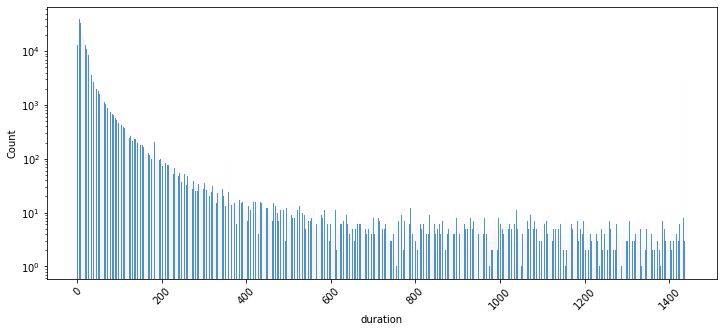

In [34]:
plt.figure(figsize = (12,5))
sns.histplot(data = df_copy, x = 'duration', stat = 'count')
plt.semilogy()
plt.xticks(rotation = 45)
plt.show()

- The variable doesn't follows a gaussian distribution, therefore, if we wanted to use a linear model we would need to transform it.
- Most of the trips are of short durations.
- The variable is limited to 1440 minutes (1 day). This may correspond to bikes taken to home and returned the next day.

Now let's see how this distribution changes for each value of the target variable:

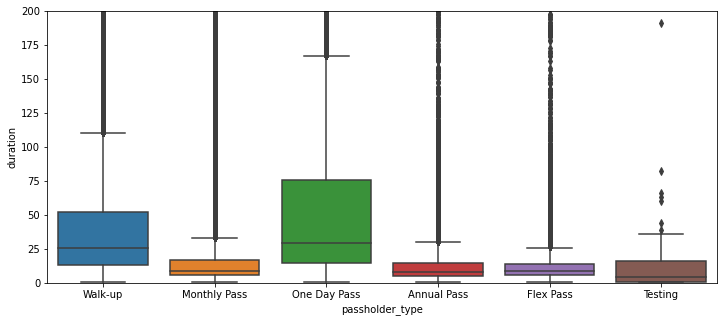

In [35]:
plt.figure(figsize = (12,5))
sns.boxplot(data = df_copy, x = 'passholder_type', y = 'duration')
plt.ylim(0, 200)
plt.show()

- The median duration of short-term passes (walk-up and one day) is higher than the median duration of long-term passes (monthly, annual and flex). Finally, the lowest median corresponds to the testing type. Thus, this variable should be important.

Furthermore, in the next plot we can observe an interaction between duration and is_roundtrip:

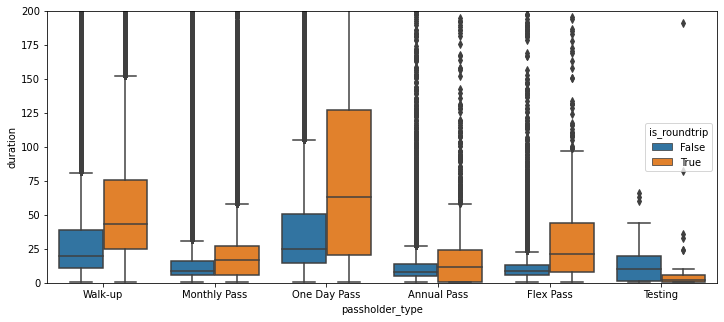

In [36]:
plt.figure(figsize = (12,5))
sns.boxplot(data = df_copy, x = 'passholder_type', y = 'duration', hue = 'is_roundtrip')
plt.ylim(0, 200)
plt.show()

### Daily demand

Let's start by analyzing the demand of each type-pass through the days of the week

In [37]:
#Extracting information from the start and end times.
df_copy['start_hour'] = df_copy['start_time'].dt.hour
df_copy['start_day_of_week'] = df_copy['start_time'].dt.day_of_week
df_copy['start_date'] = df_copy['start_time'].dt.date
df_copy['start_day_name'] = df_copy['start_time'].dt.day_name()
df_copy['start_month'] = df_copy['start_time'].dt.month
df_copy['start_year'] = df_copy['start_time'].dt.year

df_copy['end_hour'] = df_copy['end_time'].dt.hour
df_copy['end_day_of_week'] = df_copy['end_time'].dt.day_of_week
df_copy['end_date'] = df_copy['end_time'].dt.date
df_copy['end_day_name'] = df_copy['end_time'].dt.day_name()
df_copy['end_month'] = df_copy['end_time'].dt.month
df_copy['end_year'] = df_copy['end_time'].dt.year

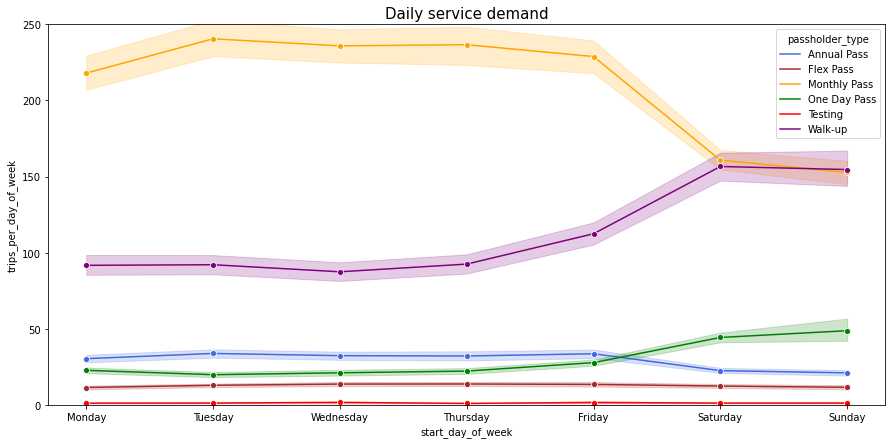

In [38]:
#Aggregating the data at daily level
df_daily = df_copy.groupby(['passholder_type','start_date','start_day_of_week','start_day_name'], as_index = False).\
agg(trips_per_day_of_week=('trip_id','size'), avg_duration=('duration','mean'))


plt.figure(figsize=(15,7))
palette = {'Annual Pass':'royalblue', 'Monthly Pass':'orange', 'One Day Pass':'green',\
           'Walk-up':'purple', 'Testing':'red','Flex Pass':'brown'}
plt.title('Daily service demand', fontsize = 15)
sns.lineplot(data = df_daily, x='start_day_of_week', y = 'trips_per_day_of_week', hue = 'passholder_type', marker='o',\
            estimator='mean', palette = palette)
plt.xticks(ticks = np.arange(0,7), labels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.ylim(0, 250)
plt.show()

- Monthly passes dominate clearly the overall activities, while Walk-up follows as the next favorite pass type, even reaching the same demand of monthly passes in the weekends. At a lower range are concentrated the annual, one day and flex passes, while at the very bottom a slight amount of test pass can be seen.

- In general, the demand tends to be constant through working days for all the pass types. Yet, short-term passes (one day and walk-up) tend to rise during weekends, as opposed to the long-term ones (monthly and annual), which have a decreasing demand during these days.

- From these observations we can infer that monthly and annual passes are mainly used by people in the workforce due to the cheaper long-term cost they offer; yet, the greater spending commitment implied in the annual pass makes it less attractive. On the other hand, the lack of commitment makes of the walk-up a good choice for the persons that don't need to use the service very often, like visiting vacationers for example. The remaining plans simply don't offer a good cost/commitment relation in general.



## Hourly Demand

Since there is a flat behaviour through business days and an abrupt change of regime in the weekends, the analysis of the hourly demand will be split into these two types of days.

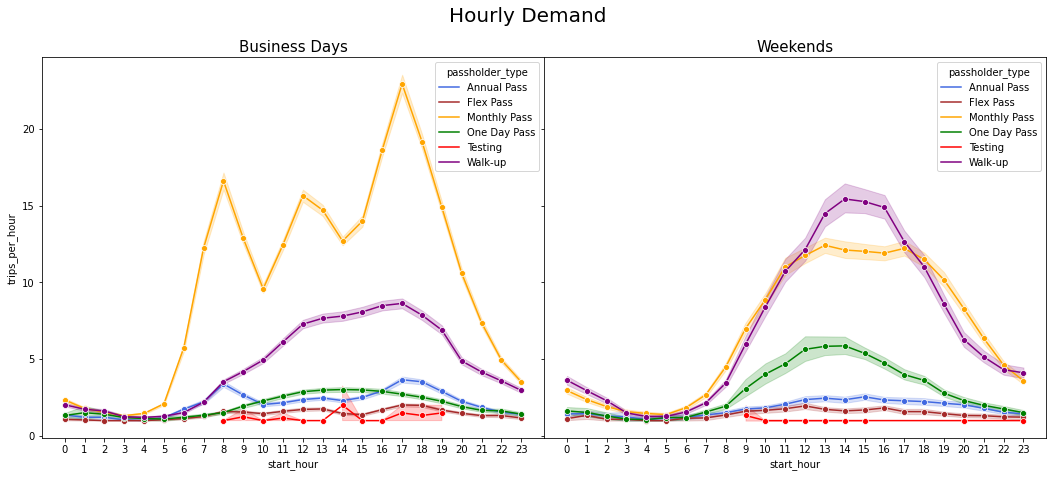

In [39]:
#Aggregating the data at an hourly level
df_hourly = df_copy.groupby(['passholder_type','start_date','start_hour','start_day_of_week'], as_index = False).\
agg(trips_per_hour=('trip_id','size'), avg_duration=('duration','mean'))


fig, ax = plt.subplots(1,2, figsize = (18,7), sharey=True)
palette = {'Annual Pass':'royalblue', 'Monthly Pass':'orange', 'One Day Pass':'green',\
           'Walk-up':'purple', 'Testing':'red','Flex Pass':'brown'}

fig.suptitle('Hourly Demand', fontsize = 20)
ax[0].set_title('Business Days', fontsize = 15)
sns.lineplot(data = df_hourly.query('start_day_of_week < 5'), x='start_hour', y = 'trips_per_hour', hue = 'passholder_type', marker='o',\
            estimator='mean', palette = palette, ax=ax[0])
ax[0].set_xticks(np.arange(0,24))

ax[1].set_title('Weekends', fontsize = 15)
sns.lineplot(data = df_hourly.query('start_day_of_week >= 5'), x='start_hour', y = 'trips_per_hour', hue = 'passholder_type', marker='o',\
            estimator='mean', palette = palette, ax=ax[1])
ax[1].set_xticks(np.arange(0,24))

fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

- Long-term passes show two peaks at 8am and 5pm during business days, thus reinforcing the idea of these passes belonging to laborers. 
- Short-term passes display a smoother hump trough the afternoon in business days, with a demand cusp somewhere between 1pm and 5pm; the lack of clear peaks in these cases is possibly explained by these passes used by a wider type of customers (workers, visitors, students, etc).

- In the case of the weekends, the peaks corresponding to workpeople are mostly vanished, displaying the mixed-type-customers hump in all the type passes. Therefore, the strong weekend's demand of the service is visible between 11am and 6pm. Finally, a slight increase in the first hours of the days is also seen.

### Yearly trend

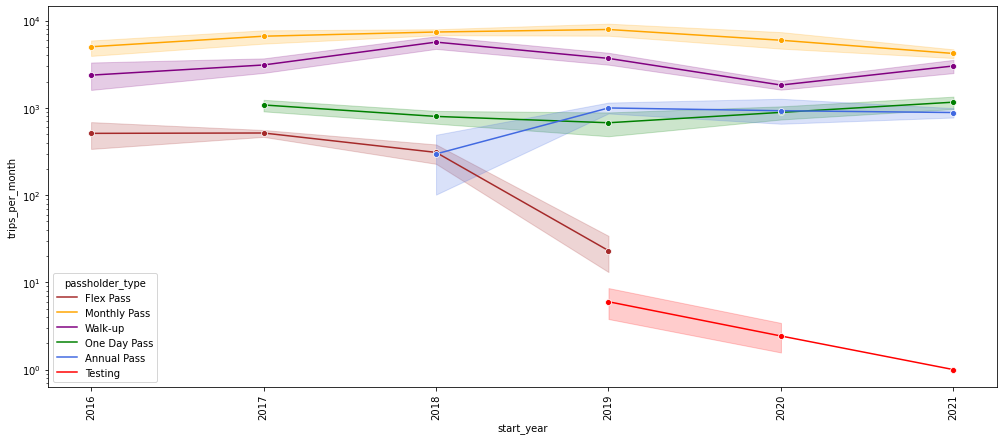

In [40]:
df_copy['year_month'] = df_copy['start_time'].dt.strftime('%Y-%m')

df_monthly = df_copy.groupby(['start_year','start_month', 'passholder_type'], as_index = False).\
                       agg(trips_per_month=('trip_id','size'))


palette = {'Annual Pass':'royalblue', 'Monthly Pass':'orange', 'One Day Pass':'green',\
           'Walk-up':'purple', 'Testing':'red','Flex Pass':'brown'}
plt.figure(figsize = (17,7))
sns.lineplot(data=df_monthly, x='start_year',y='trips_per_month',hue = 'passholder_type', marker='o', palette = palette)
plt.xticks(rotation = 90)
plt.semilogy()
plt.show()

The yearly trend simply shows that there are years where certain type of passes didn't exist. For instance, Flex Pass is not present after 2019, and in turn, the testing pass is available since this same year. Thus, a year variable will clearly be helpful in this regard.

### Clustering stations with dbscan

In order to be able to draw the locations in a map, first we rescale the coordinates from longitude and latitude units to "image" units.

In [41]:
#Rescaling the coordinates from longitude, latitude units to image units:

#dataset with all the different locations
unique_locations = pd.concat((df_copy[['start_lon','start_lat','start_station']].rename(columns={'start_lon':'lon','start_lat':'lat','start_station':'station'}),\
                df_copy[['end_lon','end_lat','end_station']].rename(columns={'end_lon':'lon','end_lat':'lat','end_station':'station'})))
unique_locations.drop_duplicates(inplace = True)


#Image size in lon, lat: upper left corner: (-118.5, 34.2), lower right corner (-118.1, 33.7)
upper_left_corner_lon = -118.5
upper_left_corner_lat = 34.2
lower_right_corner_lon = -118.1
lower_right_corner_lat = 33.7

#Size in longitude and latitude
gps_width = lower_right_corner_lon - upper_left_corner_lon
gps_height = lower_right_corner_lat - upper_left_corner_lat


from PIL import Image
#Size in image units
image = Image.open('map.png') 
img_width = image.size[0]
img_height = image.size[1]

#Positions scaled to the image size
positions_img_coord = unique_locations.copy()
positions_img_coord['lon'] = (positions_img_coord['lon'] - upper_left_corner_lon) *(img_width/gps_width)
positions_img_coord['lat'] = (positions_img_coord['lat'] - upper_left_corner_lat) *(img_height/gps_height)

Roughly speaking, the stations are distributed into five clusters (shown ahead), with a few outlier locations far from these clusters. Next, we will fit a dbscan clustering, which is more robust than kmeans when different cluster sizes are present.

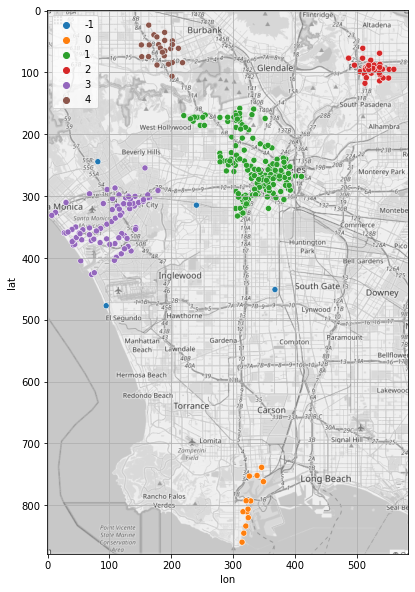

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN


scaler = StandardScaler()
model_clustering = DBSCAN(eps=0.3, min_samples = 2)


scaled_locations = scaler.fit_transform(unique_locations[['lon','lat']])
model_clustering.fit(scaled_locations)

#Creating a new df with the positions and their cluster labels
clustered_locations = unique_locations.copy()
clustered_locations['cluster'] = model_clustering.labels_


#Plotting the result
fig, axis = plt.subplots(figsize=(17, 10))
axis.imshow(image.convert('L'), cmap='gray', vmin=0, vmax=255)  # Load the image to matplotlib plot. 
sns.scatterplot(data=positions_img_coord,x='lon',y='lat', alpha = 1,ax=axis, hue = model_clustering.labels_,\
               palette = 'tab10')
axis.grid()
plt.show()

- The blue points correspond to outlier locations, defined as stations very far from station clusters. 

- The green cluster corresponds to the downtown zone.

- Thepurple cluster is close to the bay and the Santa Monica airport.

- The orange cluster is around the "World Cruise Center".

- The red cluster covers the Pasadena area.

- The browne cluster is close to the Universal, Warner and Disney studios.

In [44]:
clustered_locations

,lon,lat,station,cluster
0,-118.275192,33.748920,4127,0
1,-118.270813,34.035679,3057,1
2,-118.233093,34.046070,3022,1
3,-118.290092,34.062580,4304,1
4,-118.277687,34.026291,4266,1
...,...,...,...,...
278085,-118.238319,34.026180,4362,1
287531,-118.283730,34.013741,4468,1
431946,-118.431129,33.984821,4395,3
466091,-118.372849,34.161709,4373,4


In [45]:
#Inserting the cluster labels into the dataframe containing the rides
df_copy['start_station_cluster'] = df_copy[['start_station','start_lat','start_lon']].merge(clustered_locations,\
                                right_on = ['station','lat','lon'], how = 'left',left_on = ['start_station','start_lat','start_lon'])['cluster']

df_copy['end_station_cluster'] = df_copy[['end_station','end_lat','end_lon']].merge(clustered_locations,\
                                right_on = ['station','lat','lon'], how = 'left',left_on = ['end_station','end_lat','end_lon'])['cluster']

### Hourly Demand by clusters

Finally, we analyze the hourly demand again, but now with the more granular view provided by the clusters:

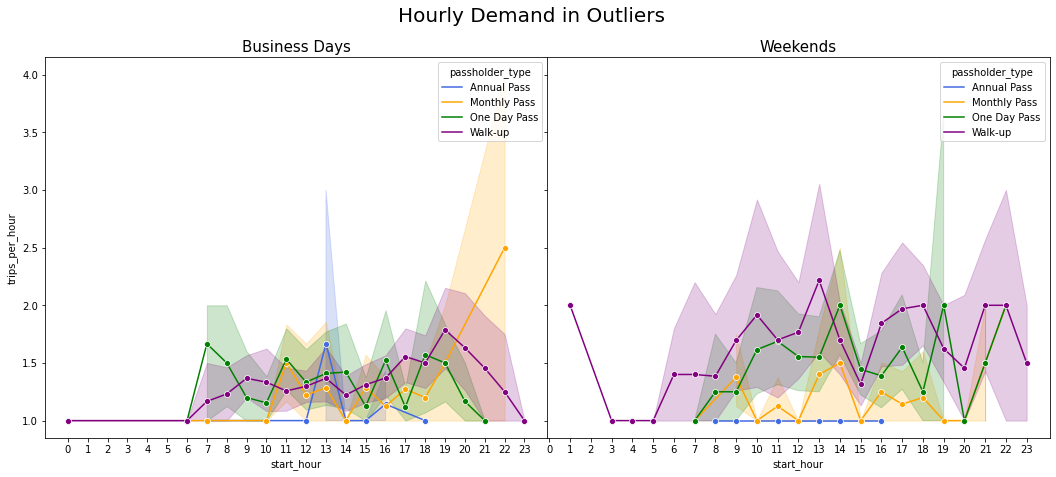

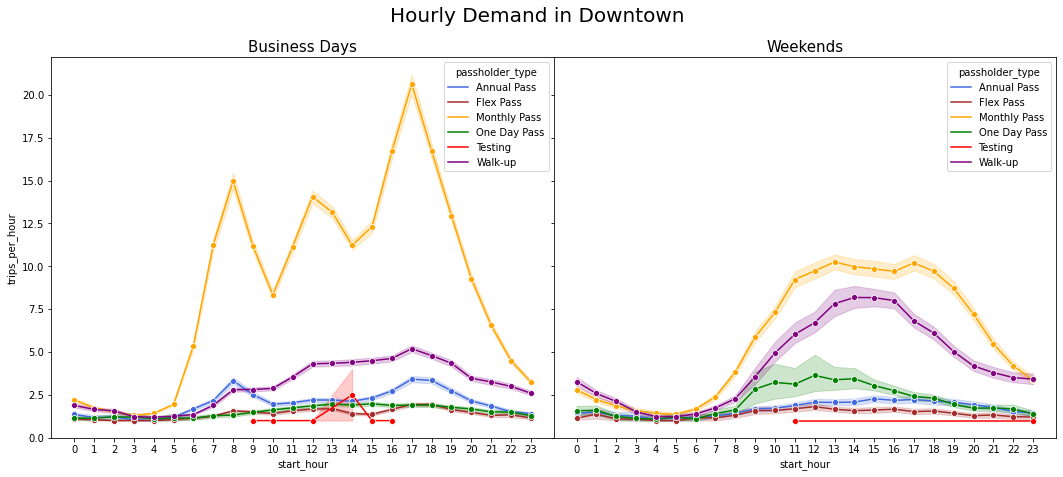

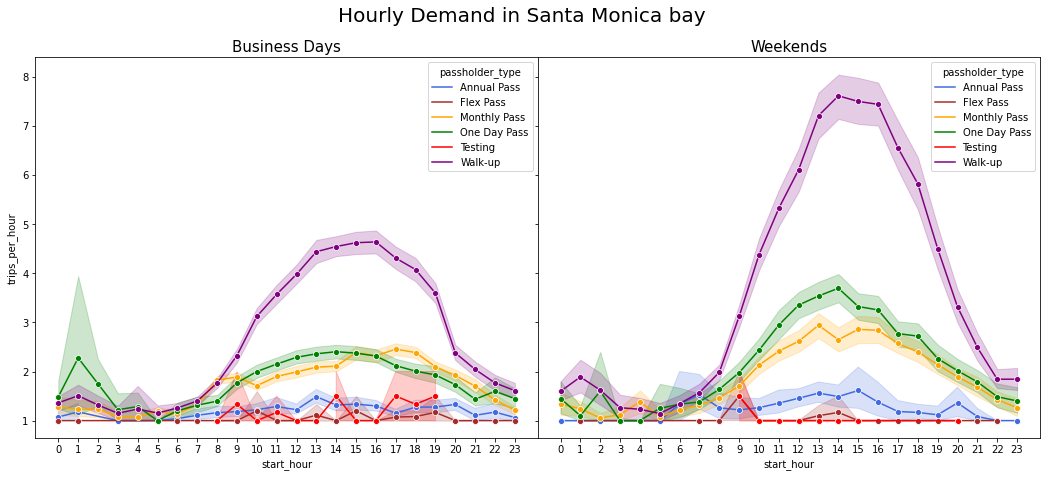

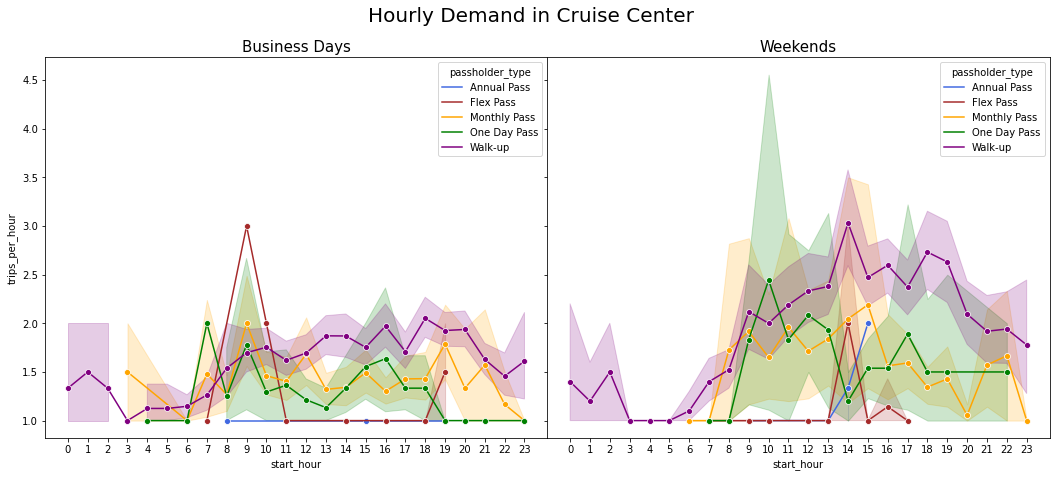

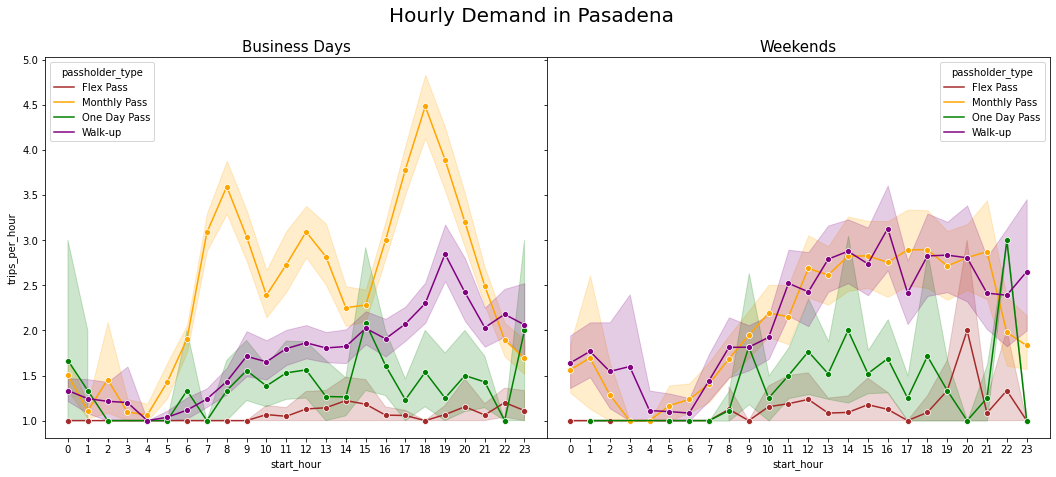

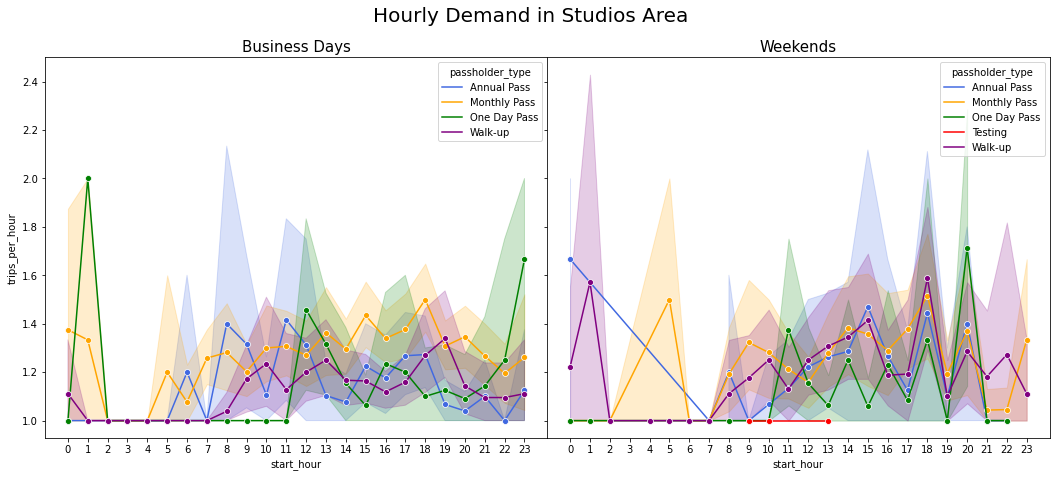

In [46]:
cluster_names = {-1:'Outliers', 1:'Downtown', 3:'Santa Monica bay', 0:'Cruise Center',2:'Pasadena',4:'Studios Area'}


for cluster_label in cluster_names:
    
    #Aggregating the data at an hourly level
    df_hourly = df_copy.query('start_station_cluster == {}'.format(cluster_label)).\
                groupby(['passholder_type','start_date','start_hour','start_day_of_week'], as_index = False).\
                agg(trips_per_hour=('trip_id','size'), avg_duration=('duration','mean'))


    fig, ax = plt.subplots(1,2, figsize = (18,7), sharey=True)
    palette = {'Annual Pass':'royalblue', 'Monthly Pass':'orange', 'One Day Pass':'green',\
               'Walk-up':'purple', 'Testing':'red','Flex Pass':'brown'}

    fig.suptitle('Hourly Demand in {}'.format(cluster_names[cluster_label]), fontsize = 20)
    ax[0].set_title('Business Days', fontsize = 15)
    sns.lineplot(data = df_hourly.query('start_day_of_week < 5'), x='start_hour', y = 'trips_per_hour', hue = 'passholder_type', marker='o',\
                estimator='mean', palette = palette, ax=ax[0])
    ax[0].set_xticks(np.arange(0,24))

    ax[1].set_title('Weekends', fontsize = 15)
    sns.lineplot(data = df_hourly.query('start_day_of_week >= 5'), x='start_hour', y = 'trips_per_hour', hue = 'passholder_type', marker='o',\
                estimator='mean', palette = palette, ax=ax[1])
    ax[1].set_xticks(np.arange(0,24))

    fig.subplots_adjust(wspace=0, hspace=0)
    plt.show()

Clearly, only the downtown, santa monica bay and pasadena clusters have enough data for a good hourly analysis.

- The dominance of monthly passes, and the peaks at 8am and 6pm in long-term passes, indicate that downtown and pasadena are clusters mostly used by workers and students.

- In turn, the dominance of short-term passes (one day and walk-up) and the lack of peaks in the santa monica bay cluster, show that this is more like a tourists cluster.

## Modelling

Before going into some benchmarks, we need to recall here that the goal of the present classification is to maximize the accuracy, even if some classes are completely misclassified.

### Benchmark with the target variable distribution

The reference benchmark will be made of predictions taking into account only the distribution of the classes of the variable of interest. 

In [48]:
#Parameters for the random generation
p = df['passholder_type'].value_counts(normalize=True).values  #Distribution of the classes
arr = df['passholder_type'].value_counts(normalize=True).index # Classes

#Random generation 
y_benchmark = np.random.choice(a=arr, size=df.shape[0], p=p)
(df['passholder_type'] == y_benchmark).value_counts(normalize=True)

False    0.579097
True     0.420903
Name: passholder_type, dtype: float64

Thus, whichever model we construct has to beat this naive approach if indeed is capturing any relevant information from the feature variables.

### Benchmark using the most frequent class in the target distribution

Another naive benchmark is made of predicting always the most frequent class of the target. Thus, in this case we would have:

In [49]:
(df['passholder_type'] == 'Monthly Pass').value_counts(normalize=True)

True     0.567636
False    0.432364
Name: passholder_type, dtype: float64

Therefore, this naiver benchmark gives a higher accuracy than predicting from the target distribution.

### Building additional features

In [48]:
#The function definition will be helpful later with the test set

def FeatureAdding(df):
    
    #
    df['is_start_missing'] = (df['start_lat'].isnull() | df['start_lon'].isnull())
    df['is_end_missing'] = (df['end_lat'].isnull() | df['end_lon'].isnull())
    
    #Converting outlier locations into NaN
    df = Outliers_to_NaN().transform(df)

    #Extracting information from the start and end times.
    df['start_hour'] = df['start_time'].dt.hour
    df['start_day_of_week'] = df['start_time'].dt.day_of_week
    df['start_date'] = df['start_time'].dt.date
    df['start_day_name'] = df['start_time'].dt.day_name()
    df['start_month'] = df['start_time'].dt.month
    df['start_year'] = df['start_time'].dt.year

    df['end_hour'] = df['end_time'].dt.hour
    df['end_day_of_week'] = df['end_time'].dt.day_of_week
    df['end_date'] = df['end_time'].dt.date
    df['end_day_name'] = df['end_time'].dt.day_name()
    df['end_month'] = df['end_time'].dt.month
    df['end_year'] = df['end_time'].dt.year


    #Tells if the trip was in weekend
    df['is_start_weekend'] = ((df['start_day_of_week'] == 5) | (df['start_day_of_week'] == 6)).astype(int)
    
    return df

In [49]:
df = FeatureAdding(df)

Another potential feature would be the distance between the start and end stations. Yet, this depends on the longitudes and latitudes prior imputation, and thus it has to be computed as a transformer in order to be introduced in a pipeline after the location imputations. Thus, the distance transformer is as follows:

In [50]:
from sklearn.base import BaseEstimator, TransformerMixin

class TripDistance(BaseEstimator, TransformerMixin):
    '''Computes the distance between start and end stations
     
    It takes a dataframe containing at least the variables start_lat, start_lon, end_lat and end_lot
    and returns a dataframe with an extra column representing the distance between the start and end
    stations'''
    
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X): 
        X_copy = X.copy()
        needed_columns = ['start_lat','start_lon','end_lat','end_lon']
        if set(needed_columns) == set(needed_columns).intersection(X_copy.keys()):        
            X_copy['trip_distance'] = np.sqrt((X_copy['start_lat'] - X_copy['end_lat'])**2 + (X_copy['start_lon'] - X_copy['end_lon'])**2)
            return X_copy
        
        else:
            print('dataset does not contains all the necessary columns')

In [51]:
from sklearn.base import BaseEstimator, TransformerMixin
class ColumnDropperTransformer(BaseEstimator, TransformerMixin):
    '''Transformer to drop columns from a dataset. Useful to use in a pipeline'''
    
    def __init__(self,columns):
        self.columns=columns

    def fit(self, X, y=None):
        return self 
    
    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

### Stratified train test split

In [52]:
df_y = df['passholder_type'].values.ravel()
df_X = df.drop(columns = 'passholder_type')

from sklearn.model_selection import train_test_split

df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_X, df_y, test_size=0.33, stratify=df_y, random_state=575)

## Random Forest

### Random Forest: Feature Selection

In [58]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

#Feature labels
##----------------------------------------------------------------------------------------------------
location_features = ['start_lon', 'start_lat', 'end_lon','end_lat']

#This features are only used for transformations and then disregarded with ColumnDropperTransformer
station_features = ['start_station','end_station'] 

datetime_features = ['start_hour','start_day_of_week','start_month','start_year','is_start_weekend']

#Features that pass unchanged
other_features = ['duration','is_roundtrip','is_start_missing','is_end_missing']
##----------------------------------------------------------------------------------------------------

#Target and predictor variables
##----------------------------------------------------------------------------------------------------
X_train = df_X_train[location_features + station_features + datetime_features + other_features].copy()
y_train = df_y_train.copy()

X_test = df_X_test[location_features + station_features + datetime_features + other_features].copy()
y_test = df_y_test.copy()
##----------------------------------------------------------------------------------------------------

##Location Imputation pipeline
# Receives location_features + station_features + 'duration' and returns location_features + 'trip_distance'
locations_imputer = Pipeline([('missing_stations', MissingStationsImputer()),\
                             ('start_location_median_imputation', GroupMedianImputer('start_station')),\
                             ('end_location_median_imputation', GroupMedianImputer('end_station')),\
                             ('dropping',ColumnDropperTransformer(['start_station','end_station','duration'])),\
                             ('distance', TripDistance())])


#Features transformation process
features_pipeline = ColumnTransformer([('location_imputation', locations_imputer, location_features+station_features+['duration']),\
                                       ('passing', 'passthrough', datetime_features+other_features)])

#Random Forest with sensible values
clf = RandomForestClassifier(n_estimators = 40, max_depth = 15, n_jobs = 4)

#Recursive Feature Elimination CV
cv=RepeatedStratifiedKFold(n_splits=2, n_repeats=3)
rfecv=RFECV(clf,min_features_to_select=4,cv=cv,scoring='accuracy',n_jobs=2,verbose=3)

#Putting all together
selection_pipeline = Pipeline([('feature_preprocessing',features_pipeline), ('rfecv',rfecv)])

#Fitting the feature selector rfecv
selection_pipeline.fit(X_train, y_train)


Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.


Pipeline(steps=[('feature_preprocessing',
                 ColumnTransformer(transformers=[('location_imputation',
                                                  Pipeline(steps=[('missing_stations',
                                                                   MissingStationsImputer()),
                                                                  ('start_location_median_imputation',
                                                                   GroupMedianImputer(group_var='start_station')),
                                                                  ('end_location_median_imputation',
                                                                   GroupMedianImputer(group_var='end_station')),
                                                                  ('dropping',
                                                                   ColumnDropperTrans...
                                                   'start_day_of_week',
                                

In [80]:
#Ranking of features (The out_names computation is not robust)
out_names = list(locations_imputer.fit_transform(X_train[location_features+station_features+['duration']]).keys()) +\
datetime_features+other_features

pd.DataFrame({'feature':out_names,'rankings':rfecv.ranking_})

,feature,rankings
0,start_lon,1
1,start_lat,1
2,end_lon,1
3,end_lat,1
4,trip_distance,1
5,start_hour,1
6,start_day_of_week,1
7,start_month,1
8,start_year,1
9,is_start_weekend,3


According with the RFECV, is_start_weekend, is_roundtrip, is_start_missing and is_end missing are not so important. Let's disregard them for now.

### Ranfom Forest: Hyperparameter Tuning

Now that we have a subset of all the features that works best, it is the turn of tuning the parameters of the model

In [82]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

#Feature labels
##----------------------------------------------------------------------------------------------------
location_features = ['start_lon', 'start_lat', 'end_lon','end_lat']

#This features are only used for transformations and then disregarded with ColumnDropperTransformer
station_features = ['start_station','end_station'] 

datetime_features = ['start_hour','start_day_of_week','start_month','start_year']

#Features that pass unchanged
other_features = ['duration']
##----------------------------------------------------------------------------------------------------

#Target and predictor variables
##----------------------------------------------------------------------------------------------------
X_train = df_X_train[location_features + station_features + datetime_features + other_features].copy()
y_train = df_y_train.copy()

X_test = df_X_test[location_features + station_features + datetime_features + other_features].copy()
y_test = df_y_test.copy()
##----------------------------------------------------------------------------------------------------

##Location Imputation pipeline
# Receives location_features + station_features + 'duration' and returns location_features + 'trip_distance'
locations_imputer = Pipeline([('missing_stations', MissingStationsImputer()),\
                             ('start_location_median_imputation', GroupMedianImputer('start_station')),\
                             ('end_location_median_imputation', GroupMedianImputer('end_station')),\
                             ('dropping',ColumnDropperTransformer(['start_station','end_station','duration'])),\
                             ('distance', TripDistance())])


#Features transformation process
features_pipeline = ColumnTransformer([('location_imputation', locations_imputer, location_features+station_features+['duration']),\
                                       ('passing', 'passthrough', datetime_features+other_features)])

#Random Forest
clf = RandomForestClassifier(n_jobs = 4)

full_pipeline = Pipeline([('feature_preprocessing',features_pipeline), ('model',clf)])

#GridSearch cv
param_grid = {"model__n_estimators":[10,20,40,50],\
              "model__max_depth": [5,7,10,15,20],\
              "model__min_samples_leaf":[1,10,50],\
              "model__max_features":['sqrt',0.5]}
cv=RepeatedStratifiedKFold(n_splits=2, n_repeats=3)
grid_model = GridSearchCV(full_pipeline, param_grid, return_train_score=True, n_jobs = 2, cv = cv, verbose=3)
grid_model.fit(X_train, y_train)

Fitting 6 folds for each of 120 candidates, totalling 720 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=2, random_state=None),
             estimator=Pipeline(steps=[('feature_preprocessing',
                                        ColumnTransformer(transformers=[('location_imputation',
                                                                         Pipeline(steps=[('missing_stations',
                                                                                          MissingStationsImputer()),
                                                                                         ('start_location_median_imputation',
                                                                                          GroupMedianImputer(group_var='start_station')),
                                                                                         ('end_location_me...
                                                                          'duration']),
                                                                 

Next we check the scores for the different parameters. We sort them by the difference between the training score and the cross validated test score:

In [108]:
grid_scores = pd.DataFrame({'mean_train_score':grid_model.cv_results_['mean_train_score'],\
                            'mean_test_score':grid_model.cv_results_['mean_test_score'],\
                            'std_train_score':grid_model.cv_results_['std_train_score'],\
                            'std_test_score':grid_model.cv_results_['std_test_score']})

grid_scores['means_score_difference'] = grid_scores['mean_train_score'] - grid_scores['mean_test_score']

grid_params = pd.DataFrame(grid_model.cv_results_['params'])

grid_search_summary = pd.concat([grid_params, grid_scores], axis = 1)

#We filter for the parameters that have less than 0.001 train score standard deviation and less than 0.01.
#As well, we sort by the maximum mean test score:
grid_search_summary.query('std_train_score<0.001 and means_score_difference<0.01').\
sort_values('mean_test_score', ascending=False).head(20)

,model__max_depth,model__max_features,model__min_samples_leaf,model__n_estimators,mean_train_score,mean_test_score,std_train_score,std_test_score,means_score_difference
95,15,0.5,50,50,0.714814,0.704945,0.000633,0.000921,0.009869
107,20,sqrt,50,50,0.714379,0.704814,0.000589,0.000908,0.009565
106,20,sqrt,50,40,0.714295,0.704655,0.000326,0.001103,0.009640
93,15,0.5,50,20,0.714260,0.704650,0.000705,0.000572,0.009610
105,20,sqrt,50,20,0.714200,0.704529,0.000912,0.001023,0.009671
104,20,sqrt,50,10,0.713643,0.703813,0.000423,0.000871,0.009829
82,15,sqrt,50,40,0.711613,0.703376,0.000585,0.000880,0.008237
83,15,sqrt,50,50,0.711774,0.703305,0.000517,0.001030,0.008469
81,15,sqrt,50,20,0.711266,0.703097,0.000469,0.001113,0.008168
80,15,sqrt,50,10,0.710601,0.702160,0.000628,0.000729,0.008441


Thus, we choose the parameters of the first row and proceed to test on the holdout set

##### Testing with the holdout set from train_test_split

In [102]:
#Random Forest
clf = RandomForestClassifier(n_estimators = 50, max_depth = 15, min_samples_leaf=50,max_features=0.5, n_jobs = 4)

full_pipeline = Pipeline([('feature_preprocessing',features_pipeline), ('model',clf)])

#Fitting the model on X_train, y_train and predicting the X_test:
full_pipeline.fit(X_train, y_train)
y_test_pred = full_pipeline.predict(X_test)
y_train_pred = full_pipeline.predict(X_train)

test_score = (y_test_pred == y_test).sum()/(len(y_test))
train_score = (y_train_pred == y_train).sum()/(len(y_train))

print('test_score: {0} train_score: {1}'.format(test_score, train_score))

test_score: 0.7113290043290044 train_score: 0.7181428571428572


Therefore, it seems that the model doesn't overfits and indeed reachs an accuracy higher than the benchmark previously established.

### Prediction

In [104]:
#Create the features for the kaggle dataset.
kaggle_test = FeatureAdding(test)

#Features values for the test
X_kaggle_test = kaggle_test[location_features + station_features + datetime_features + other_features]

y_kaggle_test = full_pipeline.predict(X_kaggle_test)

kaggle_test_prediction = pd.DataFrame({'trip_id': kaggle_test['trip_id'].values, 'passholder_type':y_kaggle_test})

In [105]:
kaggle_test_prediction.to_csv('submission2.csv', index = False)

After submitting, we get a private score of 0.708, which is in accordance with our accuracy estimations.

#### Further ideas to improve the score

- Try other models
- Use a clustering algorithm in a subset of the predictors as a preprocessor.
- Use PCA in a subset of the predictors as a preprocessor.
- Target encode is_roundtrip variable.
- Define other time features. For example, change the hour variable to quarters of the day, or months to year quarters.
- Binning the duration, hour, month, distance, or even the longitude and latitude (after computing distance).
- Since the classification is imbalanced, perhaps some form of undersampling or oversampling would help.